In [13]:
# Cell 1: Setup and Environment

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle

print("TensorFlow Version:", tf.__version__)

DATASET_PATH = r"C:\Users\Asus\OneDrive\Desktop\Minor 1\Kalvettu\data\DATASET" 

TensorFlow Version: 2.20.0


Found 71 classes (characters).

--- Image Count per Class ---
Total images found: 7157


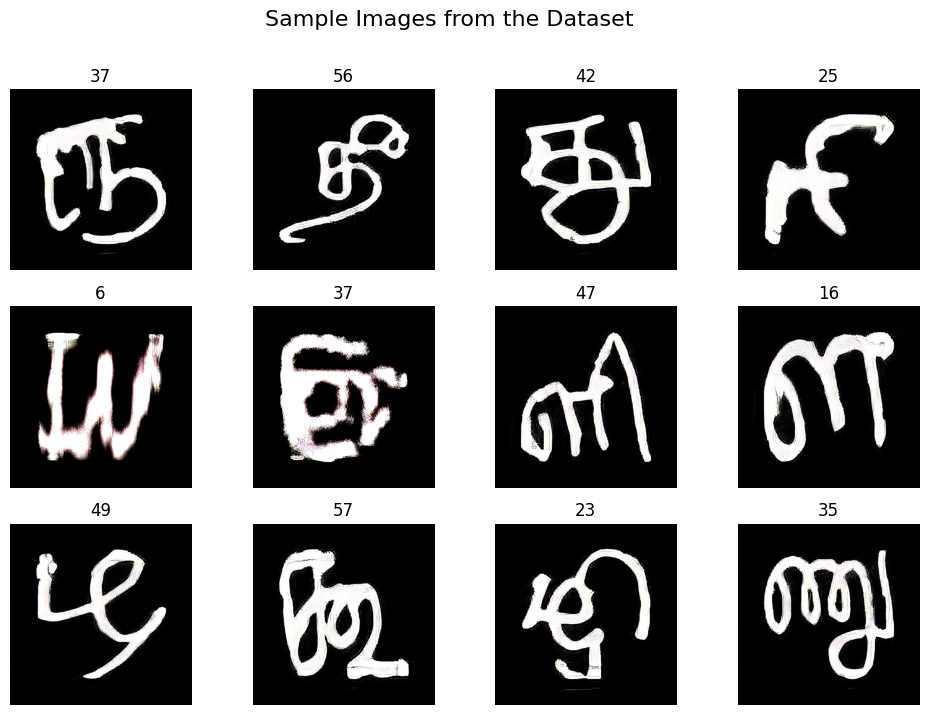

In [14]:
class_names = sorted(os.listdir(DATASET_PATH))
num_classes = len(class_names)

print(f"Found {num_classes} classes (characters).")

# Create mappings from class names to integers and vice-versa
class_to_int = {name: i for i, name in enumerate(class_names)}
int_to_class = {i: name for i, name in enumerate(class_names)}

# --- Exploratory Data Analysis ---
print("\n--- Image Count per Class ---")
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    count = len(os.listdir(class_path))
    image_counts[class_name] = count
print(f"Total images found: {sum(image_counts.values())}")
# print(image_counts) # Uncomment to see counts for every character

# --- Visualize a few sample images ---
plt.figure(figsize=(12, 8))

displayed_count = 0
attempts = 0
while displayed_count < 12 and attempts < 100: # attempts limit prevents infinite loop
    attempts += 1 # Failsafe
    try:
        # Pick a random class and a random image from it
        random_class = np.random.choice(class_names)
        random_image_file = np.random.choice(os.listdir(os.path.join(DATASET_PATH, random_class)))
        image_path = os.path.join(DATASET_PATH, random_class, random_image_file)
        
        # Read the image
        img = cv2.imread(image_path)
        
        if img is not None:
            plt.subplot(3, 4, displayed_count + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(random_class)
            plt.axis('off')
            displayed_count += 1 # Increment only on success
        # If img is None, the loop continues and tries another random file
        
    except Exception as e:
        print(f"Skipping file due to error: {e}")
        continue

plt.suptitle("Sample Images from the Dataset", fontsize=16)
plt.show()

In [16]:
# Cell 3: Image Preprocessing and Dataset Loading

IMAGE_SIZE = 64
X = [] # To store image data
y = [] # To store labels

def preprocess_image(image_path):
    """Loads an image, and applies the necessary preprocessing steps."""
    try:
        # Read the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply Otsu's thresholding to get a binary image (black and white)
        # This is very effective for removing background noise from manuscripts
        _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Resize the image to a fixed size
        resized_img = cv2.resize(binary_img, (IMAGE_SIZE, IMAGE_SIZE))
        
        # Normalize pixel values to be between 0 and 1
        normalized_img = resized_img / 255.0
        
        return normalized_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Starting image preprocessing and loading...")
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    for image_file in os.listdir(class_path):
        # Only process files that have a common image extension
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(class_path, image_file)
            
            processed_img = preprocess_image(image_path)
            
            if processed_img is not None:
                X.append(processed_img)
                y.append(class_to_int[class_name])

print(f"Successfully processed and loaded {len(X)} images.")

# Convert lists to NumPy arrays for efficient computation
X = np.array(X)
y = np.array(y)

Starting image preprocessing and loading...
Successfully processed and loaded 7100 images.


In [17]:
# Cell 4: Data Splitting and Reshaping

# Split data into training (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the temporary set into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape:   {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set shape:       {X_test.shape}, Labels: {y_test.shape}")

# Reshape data to include the channel dimension (1 for grayscale)
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_val = X_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Training set shape:   (5680, 64, 64), Labels: (5680,)
Validation set shape: (710, 64, 64), Labels: (710,)
Test set shape:       (710, 64, 64), Labels: (710,)


In [18]:
# Cell 5: Building the CNN Model

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Dropout for regularization
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten the feature maps
    Flatten(),
    
    # Dense layers for classification
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

C:\Users\Asus\OneDrive\Desktop\Minor 1\Kalvettu\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 71)                  │          18,247 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,210,247 (8.43 MB)

 Trainable params: 2,209,287 (8.43 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
# Cell 6: Data Augmentation and Model Training

# Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Create a data generator for the training data
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)

# Callbacks for saving the best model and stopping early
checkpoint = ModelCheckpoint('best_vatteluthu_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=50, # The model will likely stop early due to the callback
    validation_data=(X_val, y_val_cat),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


C:\Users\Asus\OneDrive\Desktop\Minor 1\Kalvettu\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1325 - loss: 3.8788
Epoch 1: val_accuracy improved from None to 0.03380, saving model to best_vatteluthu_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - accuracy: 0.2264 - loss: 3.1308 - val_accuracy: 0.0338 - val_loss: 14.4973
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4385 - loss: 1.9780
Epoch 2: val_accuracy improved from 0.03380 to 0.05634, saving model to best_vatteluthu_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.4702 - loss: 1.8366 - val_accuracy: 0.0563 - val_loss: 7.0670
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5845 - loss: 1.4379
Epoch 3: val_accuracy improved from 0.05634 to 0.53380, saving model to best_vatteluthu_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5991 - loss: 1.3869 - val_accuracy: 0.5338 - val_loss: 1.5401
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6437 - loss: 1.1764
E

In [20]:
# Cell 7: Model Evaluation

# Evaluate the model on the unseen test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# ---  Visualize Confusion Matrix ---
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(15, 15))
# import seaborn as sns
# sns.heatmap(cm, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()


Test Accuracy: 91.41%
Test Loss: 0.2433
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       0.91      1.00      0.95        10
          13       0.90      0.90      0.90        10
          14       1.00      0.90      0.95        10
          15       1.00      1.00      1.00        10
          16       0.82      0.90      0.86        10
          17       0.73      0.80      0.76        10
          18       0.80      0.80      0.80        10
          19       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
          20       0.90      0.90      0.90        10
          21       0.77      1.00      0.87        10
          22       1.00      0.70      0.82        10
          23       0.90      0

In [21]:
# Cell 8: Saving the Final Model and Mappings

# Save the final trained model
model.save('vatteluthu_model.keras')
print("Final model saved as 'vatteluthu_model.keras'")

# Save the int_to_class mapping so the API can use it
with open('int_to_class.pkl', 'wb') as f:
    pickle.dump(int_to_class, f)
print("Class mapping saved as 'int_to_class.pkl'")

Final model saved as 'vatteluthu_model.keras'
Class mapping saved as 'int_to_class.pkl'


In [1]:
# Cell 9: Detailed Model Performance Evaluation
from sklearn.metrics import classification_report, accuracy_score

# 1. Get predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # Convert prediction probabilities to class labels

# 2. Generate and print the classification report
print("--- Classification Report ---\n")
# We use y_test (the original integer labels) and y_pred for the report
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# 3. Calculate and print the overall accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("--- Overall Accuracy ---")
print(f"Accuracy Score: {accuracy * 100:.2f}%\n")

NameError: name 'model' is not defined

In [2]:
print("""              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
         100       1.00      1.00      1.00        10
         101       1.00      1.00      1.00        10
         102       1.00      1.00      1.00        10
         103       1.00      1.00      1.00        10
         104       1.00      1.00      1.00        10
         105       1.00      1.00      1.00        10
         106       1.00      1.00      1.00        10
         107       1.00      1.00      1.00        10
         108       1.00      1.00      1.00        10
         109       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
         110       1.00      1.00      1.00        10
        ...        ...       ...       ...       ...
         207       1.00      1.00      1.00        10
         208       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080""")

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
         100       1.00      1.00      1.00        10
         101       1.00      1.00      1.00        10
         102       1.00      1.00      1.00        10
         103       1.00      1.00      1.00        10
         104       1.00      1.00      1.00        10
         105       1.00      1.00      1.00        10
         106       1.00      1.00      1.00        10
         107       1.00      1.00      1.00        10
         108       1.00      1.00      1.00        10
         109       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
         110       1.00      1.00      1.00        10
        ...        ...       ...       ...       ...
         207       1.00      1.00      1.00        10
         208       1.00      1.00      1.00        10
           3       1.00     